# Logisitic smooth regression model

Following van der Wiel et al. 2019, let's model energy demand using a logistic smooth regression model: https://www.sciencedirect.com/science/article/pii/S1364032119302862

This takes a single predictor, daily mean temperature, and provides a smooth transition between two linear regimes.

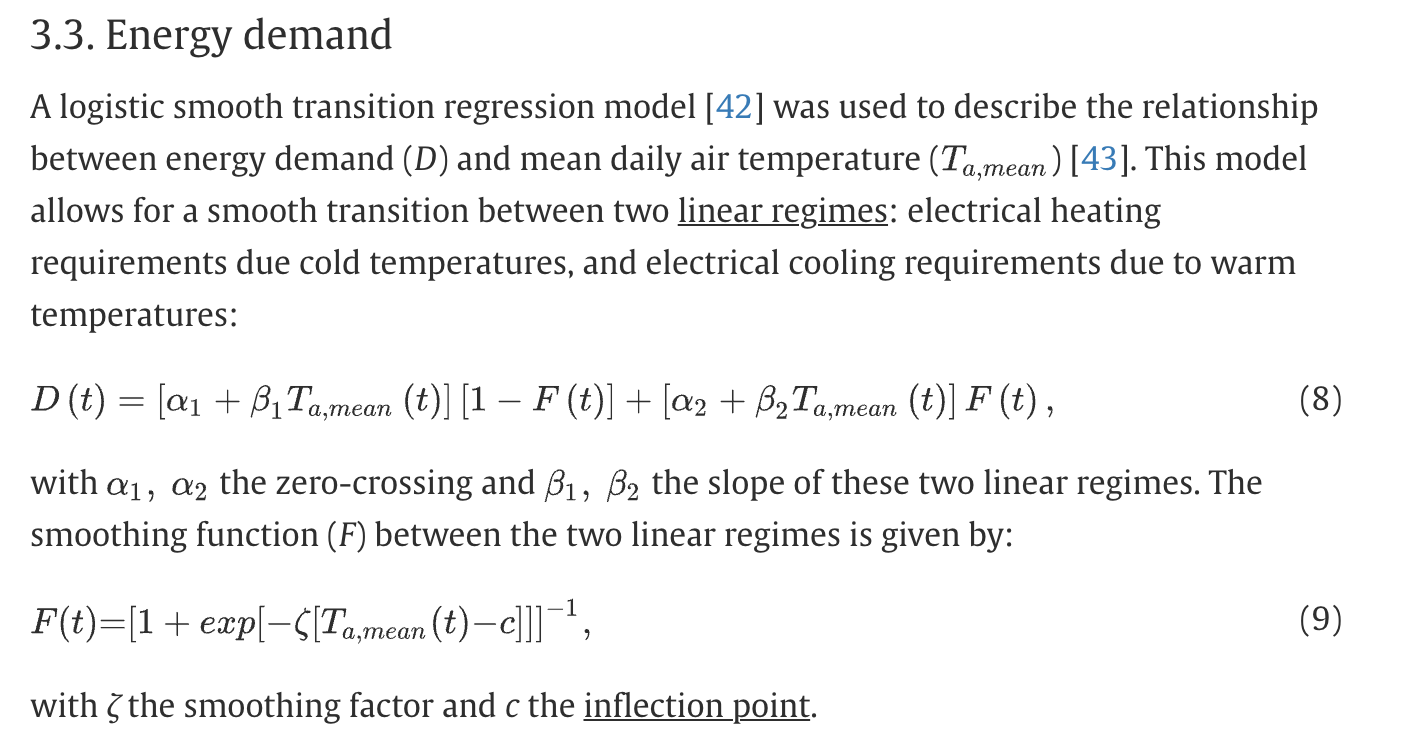

In [1]:
import xarray as xr
import numpy as np

from scipy.optimize import curve_fit

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error

from scipy.stats import spearmanr, pearsonr

import matplotlib.pyplot as plt

In [2]:
path = "/g/data/w42/dr6273/work/projects/Aus_energy/"

# Load predictors and predictands

Detrended energy demand (predictand)

In [4]:
aus_dem = xr.open_dataset(
    path + "/data/energy_demand/daily_demand_2010-2020_stl.nc"
)["demand_stl"]

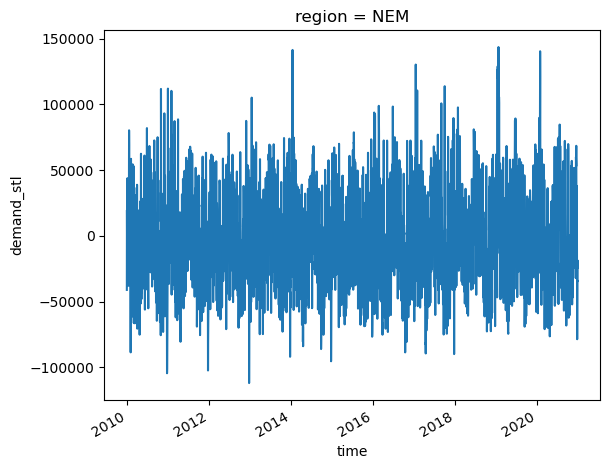

In [5]:
aus_dem.sel(region="NEM").plot()

In [5]:
# aus_dem_diff = aus_dem.diff("time", n=1)

In [6]:
# aus_dem_diff.sel(region="NEM").plot()

In [7]:
# aus_dem = aus_dem.sel(time=slice("2015", "2020"))

In [3]:
eu_dem = xr.open_dataset(
    path + "data/energy_demand/EU_daily_demand_2010-2020_detrended.nc"
)["demand_dt"]

Less demand on weekends

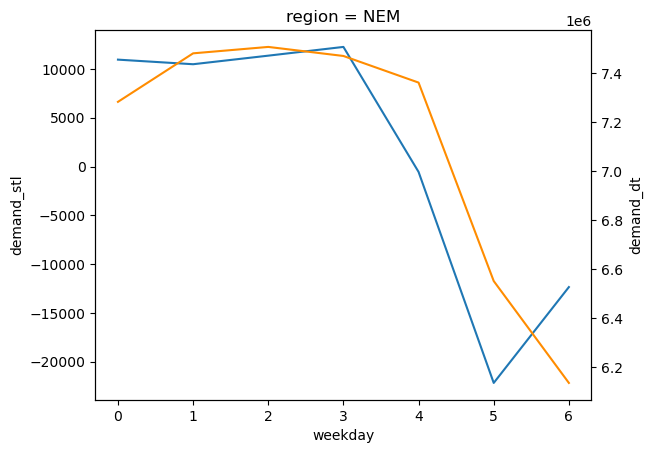

In [6]:
fig, ax = plt.subplots()
aus_dem.sel(region="NEM").groupby("time.weekday").mean().plot()
ax2 = ax.twinx()
eu_dem.groupby("time.weekday").mean().plot(ax=ax2, color="darkorange")

Some studies remove August from Europe demand as its a big holiday month. Nothing equivalent evident for NEM?

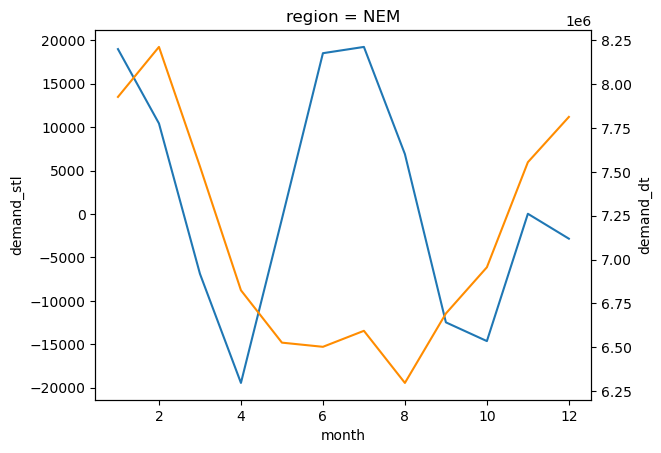

In [7]:
fig, ax = plt.subplots()
aus_dem.sel(region="NEM").groupby("time.month").mean().plot()
ax2 = ax.twinx()
eu_dem.groupby("time.month").mean().plot(ax=ax2, color="darkorange")

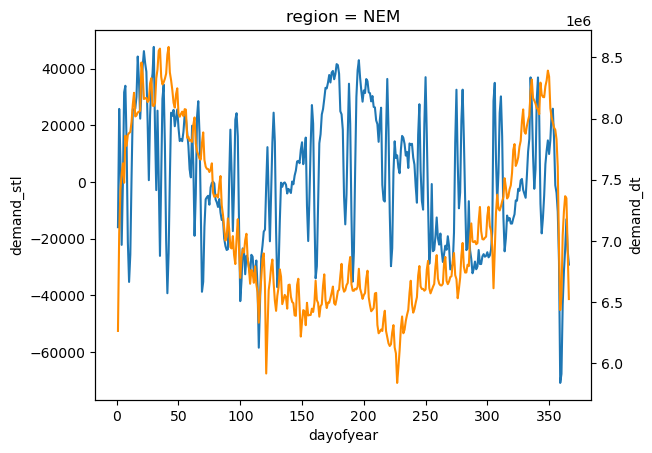

In [8]:
fig, ax = plt.subplots()
aus_dem.sel(region="NEM").groupby("time.dayofyear").mean().plot()
ax2 = ax.twinx()
eu_dem.groupby("time.dayofyear").mean().plot(ax=ax2, color="darkorange")

In [12]:
# fig, ax = plt.subplots()
# aus_dem_diff.sel(region="NEM").groupby("time.dayofyear").mean().plot()
# ax2 = ax.twinx()
# eu_dem.groupby("time.dayofyear").mean().plot(ax=ax2, color="darkorange")

Functions to exclude dates

In [9]:
def rm_weekend(da):
    """
    Set weekend days to NaN
    """
    return da.where(da.time.dt.dayofweek < 5)

In [10]:
def rm_month(da, month):
    """
    Set a particular month to NaN
    """
    return da.where(da.time.dt.month != month)

In [11]:
def rm_xmas(da):
    """
    Set 21/12 through 06/01 to NaN
    """
    da_ = da.where(
        da.where(
            (da.time.dt.month == 12) & 
            (da.time.dt.day > 20)
        ).isnull()
    )
    da_ = da_.where(
        da_.where(
            (da_.time.dt.month == 1) & 
            (da_.time.dt.day < 7)
        ).isnull()
    )
    return da_

In [12]:
def rm_nan(x):
    """
    Remove NaNs from array
    """
    return x[~np.isnan(x)]

Daily mean temperature

In [14]:
aus_t2m = xr.open_dataset(path + "demand_predictors/2t_era5_daily_1959-2022_NEM_pop_dens_mask.nc")["t2m"]

In [16]:
eu_t2m = xr.open_dataset(path + "demand_predictors/2t_era5_daily_1959-2022_EU_pop_dens_mask.nc")["t2m"]

# Model fitting functions

In [17]:
def lstr(x, a1, a2, b1, b2, z, c):
    """
    Logistic smooth transition equation
    """
    F = 1 / (1 + np.exp(-z * (x - c)))
    term1 = (a1 + b1 * x) * (1 - F)
    term2 = (a2 + b2 * x) * F
    return term1 + term2

In [18]:
# def lstr_time(x, a1, a2, b1, b2, z, c, t):
#     """
#     Logistic smooth transition equation with additional time-varying parameter t
#     """
#     F = 1 / (1 + np.exp(-z * (x - c)))
#     term1 = (a1 + b1 * x) * (1 - F)
#     term2 = (a2 + b2 * x) * F
#     return (t * x) + term1 + term2

In [19]:
def fit_model(model, xda, yda, inits):
    """
    Fit logistic smooth transition regression to data.
    """
    x = xda.values
    y = yda.values
    
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    
    params, _ = curve_fit(model, x, y, p0=inits, maxfev=25000)
    return params

# Scores

In [20]:
def compute_scores(y_true, y_pred, metrics):
    """
    Compute scores for a variety of metrics, plus pearson and spearman correlation.
    
    y_true: observations
    y_predict: predictions
    metrics: list of scores from sklearn.metrics
    """
    scores = []
    for metric in metrics:
        s = metric(y_true, y_pred)
        scores.append(s)
    cor_p, _ = pearsonr(y_true, y_pred)
    cor_s, _ = spearmanr(y_true, y_pred)
    scores.append(cor_p)
    scores.append(cor_s)
    return scores

In [21]:
def plot_time_remove_scores(x, y, month, inits):
    """
    Bar plot of MAE and r, comparing scores on all data,
    and data with some aspects removed (e.g. weekends)
    """
    def mae_cor(x, y):
        a1, a2, b1, b2, z, c = fit_model(lstr, x, y, inits=inits)
        pred = lstr(x.values, a1, a2, b1, b2, z, c)
        y = rm_nan(y)
        pred = rm_nan(pred)
        return compute_scores(y, pred, [mean_absolute_error])[:2]

    mae = []
    cor = []
    
    m, c = mae_cor(x, y)
    mae.append(m)
    cor.append(c)

    x_ = rm_weekend(x)
    y_ = rm_weekend(y)
    m, c = mae_cor(x_, y_)
    mae.append(m)
    cor.append(c)

    x_ = rm_month(x, month)
    y_ = rm_month(y, month)
    m, c = mae_cor(x_, y_)
    mae.append(m)
    cor.append(c)

    x_ = rm_xmas(x)
    y_ = rm_xmas(y)
    m, c = mae_cor(x_, y_)
    mae.append(m)
    cor.append(c)

    x_ = rm_weekend(x)
    x_ = rm_xmas(x_)
    y_ = rm_weekend(y)
    y_ = rm_xmas(y_)
    m, c = mae_cor(x_, y_)
    mae.append(m)
    cor.append(c)

    x_ = rm_weekend(x)
    x_ = rm_xmas(x_)
    x_ = rm_month(x_, 8)
    y_ = rm_weekend(y)
    y_ = rm_month(y_, 8)
    y_ = rm_xmas(y_)
    m, c = mae_cor(x_, y_)
    mae.append(m)
    cor.append(c)
    
    fig, ax = plt.subplots(2, 1)
    xlabels = ["None", "Wknd", "Month "+str(month), "Xmas", "Wknd+Xmas", "All"]
    ax[0].bar(xlabels, mae)
    ax[0].set_ylabel("MAE")
    ax[1].bar(xlabels, cor)
    ax[1].set_ylabel("Pearson r")

In [22]:
metrics = [mean_absolute_error]
metric_names = ["MAE", "Pearson cor", "Spearman cor"]

# Plotting functions

In [23]:
def plot_fit(ax, x_scatter, y_scatter, x_fit, y_fit, title):
    """
    Scatter plot of demand vs temperature with model fit line
    """
    ax.scatter(x_scatter, y_scatter, alpha=0.3, s=10)
    ax.plot(x_fit, y_fit, color="r")
    ax.set_xlabel("Temperature [deg C]")
    ax.set_ylabel("Demand [GWh/day]")
    ax.set_title(title)

In [24]:
def plot_ts(ax, x1, x2, title):
    """
    Timeseries and fit stats
    """
    ax.plot(x1, lw=0.7)
    ax.plot(x2, lw=0.8)
    ax.set_xlabel("Time [day]")
    ax.set_ylabel("Demand [GWh/day]")
    ax.set_title(title)

# NEM model

Need to guess starting parameter values otherwise fitting will fail

In [27]:
aus_init = [-6e6, -4e3, 2e3, 2e1, 0.2, 0]

Model performance with time removed

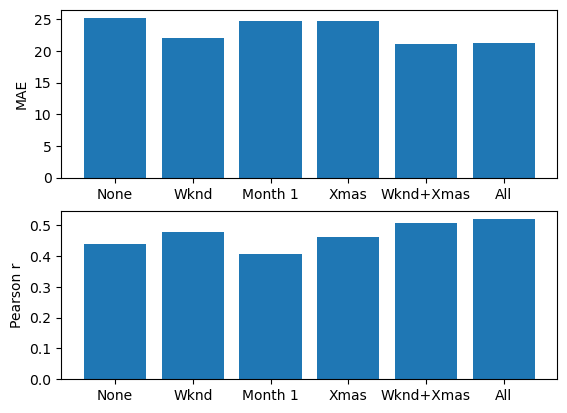

In [28]:
plot_time_remove_scores(
    aus_t2m.sel(region="NEM", time=aus_dem["time"]) - 273.15,
    aus_dem.sel(region="NEM") / 1000,
    1,
    aus_init
)

In [29]:
# plot_time_remove_scores(
#     aus_t2m.sel(region="NEM", time=aus_dem_diff["time"]) - 273.15,
#     aus_dem_diff.sel(region="NEM") / 1000,
#     1,
#     aus_init
# )

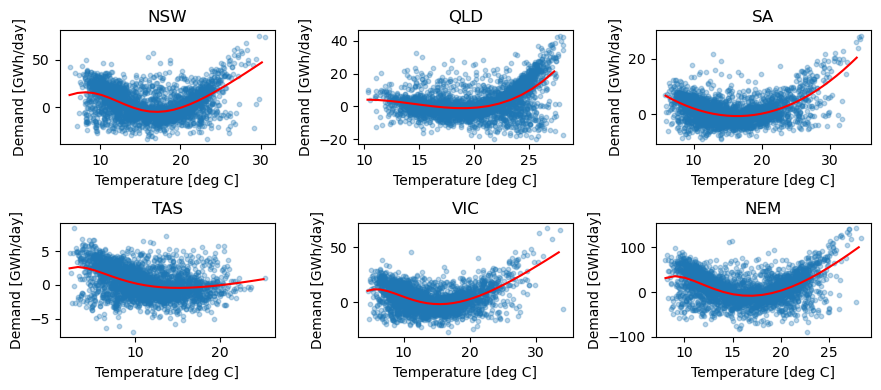

In [30]:
fig, ax = plt.subplots(2, 3, figsize=(9,4))
for i, region in enumerate(aus_dem["region"].values):
    
    t = aus_t2m.sel(region=region, time=aus_dem["time"]) - 273.15
    d = aus_dem.sel(region=region) / 1000
    
    t = rm_weekend(t)
    t = rm_xmas(t)
    t = rm_nan(t)
    
    d = rm_weekend(d)
    d = rm_xmas(d)
    d = rm_nan(d)
    
    a1, a2, b1, b2, z, c = fit_model(lstr, t, d, inits=aus_init)
    x_line = np.arange(min(t.values), max(t.values), 1)
    y_line = lstr(x_line, a1, a2, b1, b2, z, c)
    
    a = ax.flatten()[i]
    plot_fit(a, t, d, x_line, y_line, region)
plt.tight_layout()

In [31]:
# fig, ax = plt.subplots(2, 3, figsize=(9,4))
# for i, region in enumerate(aus_dem["region"].values):
    
#     t = aus_t2m.sel(region=region, time=aus_dem_diff["time"]) - 273.15
#     d = aus_dem_diff.sel(region=region) / 1000
    
#     t = rm_weekend(t)
#     t = rm_xmas(t)
#     t = rm_nan(t)
#     d = rm_weekend(d)
#     d = rm_xmas(d)
#     d = rm_nan(d)
    
#     a1, a2, b1, b2, z, c = fit_model(lstr, t, d, inits=aus_init)
#     x_line = np.arange(min(t.values), max(t.values), 1)
#     y_line = lstr(x_line, a1, a2, b1, b2, z, c)
    
#     a = ax.flatten()[i]
#     plot_fit(a, t, d, x_line, y_line, region)
# plt.tight_layout()

In [32]:
# aus_init_time = [-6e6, -4e3, 2e3, 2e1, 0.2, 0, -1]

# fig, ax = plt.subplots(2, 3, figsize=(9,4))
# for i, region in enumerate(aus_dem["region"].values):
    
#     t = aus_t2m.sel(region=region, time=aus_dem["time"]) - 273.15
#     d = aus_dem.sel(region=region) / 1000
    
#     t = rm_weekend(t)
#     t = rm_xmas(t)
#     t = rm_nan(t)
#     d = rm_weekend(d)
#     d = rm_xmas(d)
#     d = rm_nan(d)
    
#     a1, a2, b1, b2, z, c, tc = fit_model(lstr_time, t, d, inits=aus_init_time)
#     x_line = np.arange(min(t.values), max(t.values), 1)
#     y_line = lstr_time(x_line, a1, a2, b1, b2, z, c, tc)
    
#     a = ax.flatten()[i]
#     plot_fit(a, t, d, x_line, y_line, region)
# plt.tight_layout()

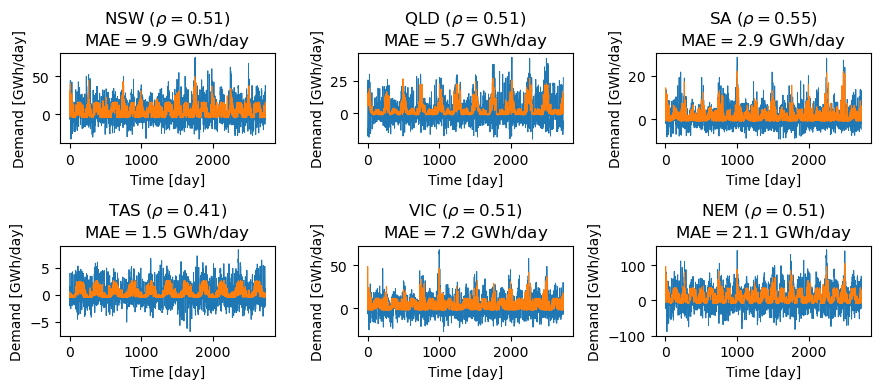

In [33]:
fig, ax = plt.subplots(2, 3, figsize=(9,4))
for i, region in enumerate(aus_dem["region"].values):
    
    t = aus_t2m.sel(region=region, time=aus_dem["time"]) - 273.15
    d = aus_dem.sel(region=region) / 1000
    
    t = rm_weekend(t)
    t = rm_xmas(t)
    t = rm_nan(t)
    d = rm_weekend(d)
    d = rm_xmas(d)
    d = rm_nan(d)
    
    a1, a2, b1, b2, z, c = fit_model(lstr, t, d, inits=aus_init)
    pred = lstr(t.values, a1, a2, b1, b2, z, c)
    
    mae, cor, _ = compute_scores(d, pred, metrics)
    # cor, _ = np.round(pearsonr(d, pred), 2)
    # # rmse = np.round(np.sqrt(mean_squared_error(d, pred)), 2)
    # mae = np.round(mean_absolute_error(d, pred), 2)
    
    title = region + r" ($\rho=$"+str(np.round(cor, 2)) + ")\n" + r"MAE$=$" + str(np.round(mae, 1)) + " GWh/day"
    a = ax.flatten()[i]
    plot_ts(a, d, pred, title)
plt.tight_layout()

In [33]:
# fig, ax = plt.subplots(2, 3, figsize=(9,4))
# for i, region in enumerate(aus_dem["region"].values):
    
#     t = aus_t2m.sel(region=region, time=aus_dem["time"]) - 273.15
#     d = aus_dem.sel(region=region) / 1000
    
#     t = rm_weekend(t)
#     t = rm_xmas(t)
#     t = rm_nan(t)
#     d = rm_weekend(d)
#     d = rm_xmas(d)
#     d = rm_nan(d)
    
#     a1, a2, b1, b2, z, c, tc = fit_model(lstr_time, t, d, inits=aus_init_time)
#     pred = lstr_time(t.values, a1, a2, b1, b2, z, c, tc)
    
#     mae, cor, _ = compute_scores(d, pred, metrics)
#     # cor, _ = np.round(pearsonr(d, pred), 2)
#     # # rmse = np.round(np.sqrt(mean_squared_error(d, pred)), 2)
#     # mae = np.round(mean_absolute_error(d, pred), 2)
    
#     title = region + r" ($\rho=$"+str(np.round(cor, 2)) + ")\n" + r"MAE$=$" + str(np.round(mae, 1)) + " GWh/day"
#     a = ax.flatten()[i]
#     plot_ts(a, d, pred, title)
# plt.tight_layout()

In [41]:
# fig, ax = plt.subplots(2, 3, figsize=(9,4))
# for i, region in enumerate(aus_dem["region"].values):
    
#     t = aus_t2m.diff("time").sel(region=region, time=aus_dem_diff["time"]) - 273.15
#     d = aus_dem_diff.sel(region=region) / 1000
    
#     t = rm_weekend(t)
#     t = rm_xmas(t)
#     t = rm_nan(t)
#     d = rm_weekend(d)
#     d = rm_xmas(d)
#     d = rm_nan(d)
    
#     a1, a2, b1, b2, z, c = fit_model(lstr, t, d, inits=aus_init)
#     pred = lstr(t.values, a1, a2, b1, b2, z, c)
    
#     mae, cor, _ = compute_scores(d, pred, metrics)
#     # cor, _ = np.round(pearsonr(d, pred), 2)
#     # # rmse = np.round(np.sqrt(mean_squared_error(d, pred)), 2)
#     # mae = np.round(mean_absolute_error(d, pred), 2)
    
#     title = region + r" ($\rho=$"+str(np.round(cor, 2)) + ")\n" + r"MAE$=$" + str(np.round(mae, 1)) + " GWh/day"
#     a = ax.flatten()[i]
#     plot_ts(a, d, pred, title)
# plt.tight_layout()

### Europe

In [44]:
eu_init = [500, 300, -2, 2, 0.5, 10]

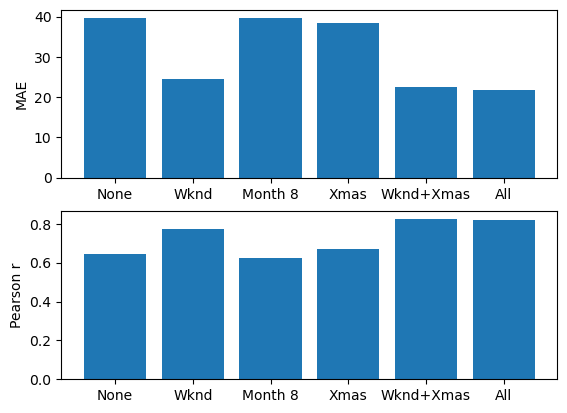

In [45]:
plot_time_remove_scores(
    eu_t2m.sel(time=eu_dem.time) - 273.15,
    eu_dem / 1000,
    8,
    eu_init
)

606.4131947638498 -2.091802745785772 442.278320594265 2.1830885748425044 0.40415309966821783 9.276177684675684


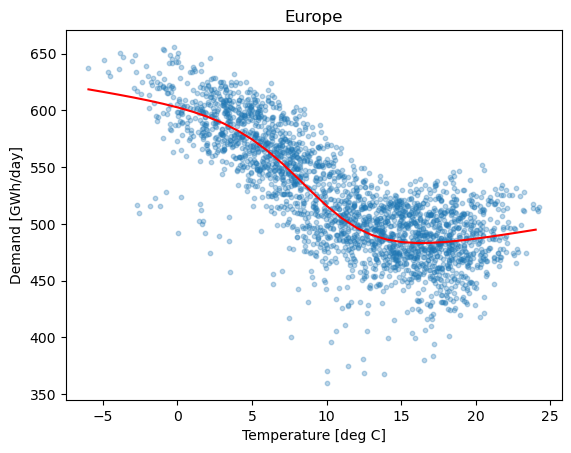

In [46]:
fig, ax = plt.subplots()
    
t = eu_t2m.sel(time=eu_dem["time"]) - 273.15
d = eu_dem / 1000

t = rm_weekend(t)
t = rm_xmas(t)
t = rm_nan(t)
d = rm_weekend(d)
d = rm_xmas(d)
d = rm_nan(d)

a1, a2, b1, b2, z, c = fit_model(lstr, t, d, inits=eu_init)
print(a1, b1, a2, b2, z, c)
x_line = np.arange(np.nanmin(t.values), np.nanmax(t.values), 1)
y_line = lstr(x_line, a1, a2, b1, b2, z, c)

plot_fit(ax, t, d, x_line, y_line, "Europe")

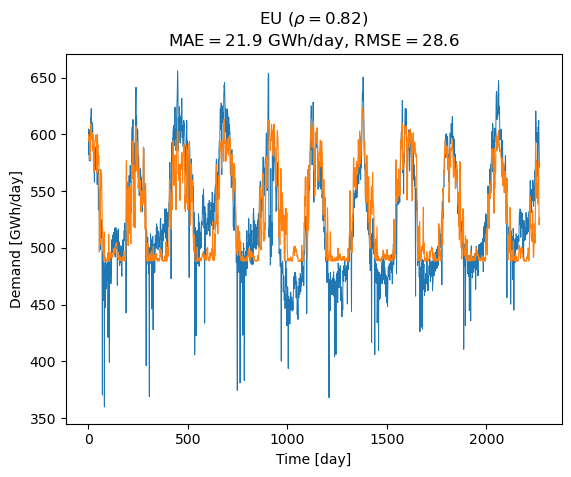

In [47]:
fig, ax = plt.subplots()
    
t = eu_t2m.sel(time=eu_dem["time"]) - 273.15
d = eu_dem / 1000

t = rm_weekend(t)
t = rm_xmas(t)
t = rm_month(t, 8)
t = rm_nan(t)
d = rm_weekend(d)
d = rm_xmas(d)
d = rm_month(d, 8)
d = rm_nan(d)

a1, a2, b1, b2, z, c = fit_model(lstr, t, d, inits=eu_init)
pred = lstr(t.values, a1, a2, b1, b2, z, c)

mae, cor, _ = compute_scores(d, pred, metrics)
rmse = np.sqrt(mean_squared_error(d, pred))

title = "EU" + r" ($\rho=$"+str(np.round(cor, 2)) + ")\n" + r"MAE$=$" + str(np.round(mae, 1)) + " GWh/day, RMSE$=$" + str(np.round(rmse, 1))
plot_ts(ax, d, pred, title)

### out of sample

In [91]:
def out_of_sample(x, y, n, init):
    """
    Boxplot of MAE and r from repeated out of sample fits
    """
    mae = []
    cor = []

    for i in range(n):
        train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=i)

        a1, a2, b1, b2, z, c = fit_model(lstr, train_X, train_y, inits=init)
        pred = lstr(test_X.values, a1, a2, b1, b2, z, c)

        m, c_, _ = compute_scores(test_y, pred, [mean_absolute_error])
        mae.append(m)
        cor.append(c_)
        
    fig, ax = plt.subplots(1, 2)
    ax[0].boxplot(mae)
    ax[0].set_xlabel("MAE")
    ax[0].set_ylabel("MAE (GWh/day)")
    ax[1].boxplot(cor)
    ax[1].set_xlabel("Correlation")
    ax[1].set_ylabel(r"$r$ [-]")
    
    plt.tight_layout()

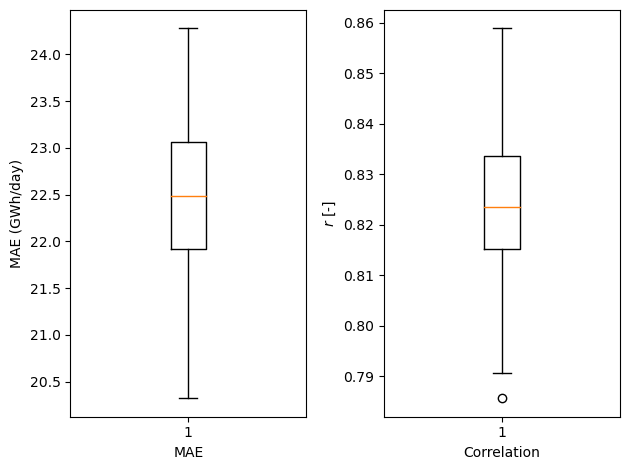

In [92]:
t = eu_t2m.sel(time=eu_dem["time"]) - 273.15
d = eu_dem / 1000

t = rm_weekend(t)
t = rm_xmas(t)
t = rm_nan(t)
d = rm_weekend(d)
d = rm_xmas(d)
d = rm_nan(d)

out_of_sample(t, d, 100, eu_init)

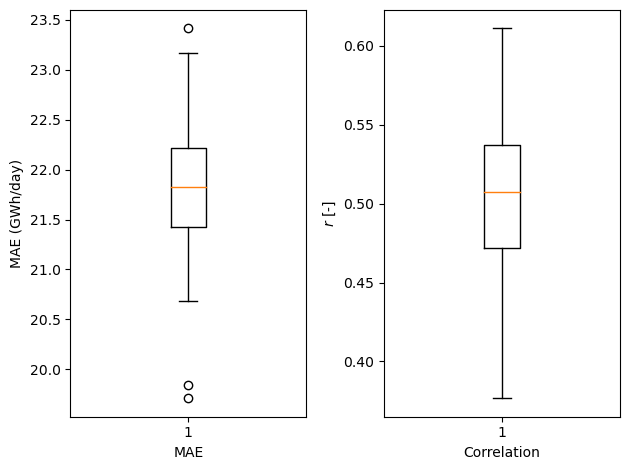

In [94]:
region="NEM"

t = aus_t2m.sel(region=region, time=aus_dem["time"]) - 273.15
d = aus_dem.sel(region=region) / 1000

t = rm_weekend(t)
t = rm_xmas(t)
t = rm_nan(t)
d = rm_weekend(d)
d = rm_xmas(d)
d = rm_nan(d)

out_of_sample(t, d, 100, aus_init)